In [1]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.ml.linalg import Vectors

from pyspark.ml import Pipeline
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler, ChiSqSelector
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import mean , col, regexp_extract
from pyspark.sql.functions import explode, split, count, when
from pyspark.sql.functions import col, lit, sum as spark_sum
from functools import reduce
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType, TimestampType, BooleanType, DoubleType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import to_json, struct
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml.linalg import VectorUDT


In [2]:

# Initialize Spark session
spark = SparkSession.builder \
    .appName("SparkToKafkaBatch") \
    .getOrCreate()


random_seed = 42

# Define your partitioning strategy based on a key column
partition_col = 'id'  # Replace with your actual column for partitioning

# Define a window specification
windowSpec = Window.partitionBy(partition_col).orderBy('match_date')


GBT_List = []
random_forest_List = []
decision_tree_List = []
Linear_regression_List =[]
SVC_List = []
KNN_List = []

24/08/21 20:29:13 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


csv_file_path = "train.csv"
train_df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Show DataFrame
train_df.show()

In [3]:

# Define the df schema
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("target", StringType(), True),
    StructField("home_team_name", StringType(), True),
    StructField("away_team_name", StringType(), True),
    StructField("match_date", TimestampType(), True),
    StructField("league_name", StringType(), True),
    StructField("league_id", IntegerType(), True),
    StructField("is_cup", BooleanType(), True),
    StructField("home_team_coach_id", DoubleType(), True),
    StructField("away_team_coach_id", DoubleType(), True),

    # Home team history fields
    StructField("home_team_history_match_date_1", TimestampType(), True),
    StructField("home_team_history_match_date_2", TimestampType(), True),
    StructField("home_team_history_match_date_3", TimestampType(), True),
    StructField("home_team_history_match_date_4", TimestampType(), True),
    StructField("home_team_history_match_date_5", TimestampType(), True),
    StructField("home_team_history_match_date_6", TimestampType(), True),
    StructField("home_team_history_match_date_7", TimestampType(), True),
    StructField("home_team_history_match_date_8", TimestampType(), True),
    StructField("home_team_history_match_date_9", TimestampType(), True),
    StructField("home_team_history_match_date_10", TimestampType(), True),
    StructField("home_team_history_is_play_home_1", DoubleType(), True),
    StructField("home_team_history_is_play_home_2", DoubleType(), True),
    StructField("home_team_history_is_play_home_3", DoubleType(), True),
    StructField("home_team_history_is_play_home_4", DoubleType(), True),
    StructField("home_team_history_is_play_home_5", DoubleType(), True),
    StructField("home_team_history_is_play_home_6", DoubleType(), True),
    StructField("home_team_history_is_play_home_7", DoubleType(), True),
    StructField("home_team_history_is_play_home_8", DoubleType(), True),
    StructField("home_team_history_is_play_home_9", DoubleType(), True),
    StructField("home_team_history_is_play_home_10", DoubleType(), True),
    StructField("home_team_history_is_cup_1", DoubleType(), True),
    StructField("home_team_history_is_cup_2", DoubleType(), True),
    StructField("home_team_history_is_cup_3", DoubleType(), True),
    StructField("home_team_history_is_cup_4", DoubleType(), True),
    StructField("home_team_history_is_cup_5", DoubleType(), True),
    StructField("home_team_history_is_cup_6", DoubleType(), True),
    StructField("home_team_history_is_cup_7", DoubleType(), True),
    StructField("home_team_history_is_cup_8", DoubleType(), True),
    StructField("home_team_history_is_cup_9", DoubleType(), True),
    StructField("home_team_history_is_cup_10", DoubleType(), True),
    StructField("home_team_history_goal_1", DoubleType(), True),
    StructField("home_team_history_goal_2", DoubleType(), True),
    StructField("home_team_history_goal_3", DoubleType(), True),
    StructField("home_team_history_goal_4", DoubleType(), True),
    StructField("home_team_history_goal_5", DoubleType(), True),
    StructField("home_team_history_goal_6", DoubleType(), True),
    StructField("home_team_history_goal_7", DoubleType(), True),
    StructField("home_team_history_goal_8", DoubleType(), True),
    StructField("home_team_history_goal_9", DoubleType(), True),
    StructField("home_team_history_goal_10", DoubleType(), True),
    StructField("home_team_history_opponent_goal_1", DoubleType(), True),
    StructField("home_team_history_opponent_goal_2", DoubleType(), True),
    StructField("home_team_history_opponent_goal_3", DoubleType(), True),
    StructField("home_team_history_opponent_goal_4", DoubleType(), True),
    StructField("home_team_history_opponent_goal_5", DoubleType(), True),
    StructField("home_team_history_opponent_goal_6", DoubleType(), True),
    StructField("home_team_history_opponent_goal_7", DoubleType(), True),
    StructField("home_team_history_opponent_goal_8", DoubleType(), True),
    StructField("home_team_history_opponent_goal_9", DoubleType(), True),
    StructField("home_team_history_opponent_goal_10", DoubleType(), True),
    StructField("home_team_history_rating_1", DoubleType(), True),
    StructField("home_team_history_rating_2", DoubleType(), True),
    StructField("home_team_history_rating_3", DoubleType(), True),
    StructField("home_team_history_rating_4", DoubleType(), True),
    StructField("home_team_history_rating_5", DoubleType(), True),
    StructField("home_team_history_rating_6", DoubleType(), True),
    StructField("home_team_history_rating_7", DoubleType(), True),
    StructField("home_team_history_rating_8", DoubleType(), True),
    StructField("home_team_history_rating_9", DoubleType(), True),
    StructField("home_team_history_rating_10", DoubleType(), True),
    StructField("home_team_history_opponent_rating_1", DoubleType(), True),
    StructField("home_team_history_opponent_rating_2", DoubleType(), True),
    StructField("home_team_history_opponent_rating_3", DoubleType(), True),
    StructField("home_team_history_opponent_rating_4", DoubleType(), True),
    StructField("home_team_history_opponent_rating_5", DoubleType(), True),
    StructField("home_team_history_opponent_rating_6", DoubleType(), True),
    StructField("home_team_history_opponent_rating_7", DoubleType(), True),
    StructField("home_team_history_opponent_rating_8", DoubleType(), True),
    StructField("home_team_history_opponent_rating_9", DoubleType(), True),
    StructField("home_team_history_opponent_rating_10", DoubleType(), True),
    StructField("home_team_history_coach_1", DoubleType(), True),
    StructField("home_team_history_coach_2", DoubleType(), True),
    StructField("home_team_history_coach_3", DoubleType(), True),
    StructField("home_team_history_coach_4", DoubleType(), True),
    StructField("home_team_history_coach_5", DoubleType(), True),
    StructField("home_team_history_coach_6", DoubleType(), True),
    StructField("home_team_history_coach_7", DoubleType(), True),
    StructField("home_team_history_coach_8", DoubleType(), True),
    StructField("home_team_history_coach_9", DoubleType(), True),
    StructField("home_team_history_coach_10", DoubleType(), True),
    StructField("home_team_history_league_id_1", DoubleType(), True),
    StructField("home_team_history_league_id_2", DoubleType(), True),
    StructField("home_team_history_league_id_3", DoubleType(), True),
    StructField("home_team_history_league_id_4", DoubleType(), True),
    StructField("home_team_history_league_id_5", DoubleType(), True),
    StructField("home_team_history_league_id_6", DoubleType(), True),
    StructField("home_team_history_league_id_7", DoubleType(), True),
    StructField("home_team_history_league_id_8", DoubleType(), True),
    StructField("home_team_history_league_id_9", DoubleType(), True),
    StructField("home_team_history_league_id_10", DoubleType(), True),

    # Away team history fields
    StructField("away_team_history_match_date_1", TimestampType(), True),
    StructField("away_team_history_match_date_2", TimestampType(), True),
    StructField("away_team_history_match_date_3", TimestampType(), True),
    StructField("away_team_history_match_date_4", TimestampType(), True),
    StructField("away_team_history_match_date_5", TimestampType(), True),
    StructField("away_team_history_match_date_6", TimestampType(), True),
    StructField("away_team_history_match_date_7", TimestampType(), True),
    StructField("away_team_history_match_date_8", TimestampType(), True),
    StructField("away_team_history_match_date_9", TimestampType(), True),
    StructField("away_team_history_match_date_10", TimestampType(), True),
    StructField("away_team_history_is_play_home_1", DoubleType(), True),
    StructField("away_team_history_is_play_home_2", DoubleType(), True),
    StructField("away_team_history_is_play_home_3", DoubleType(), True),
    StructField("away_team_history_is_play_home_4", DoubleType(), True),
    StructField("away_team_history_is_play_home_5", DoubleType(), True),
    StructField("away_team_history_is_play_home_6", DoubleType(), True),
    StructField("away_team_history_is_play_home_7", DoubleType(), True),
    StructField("away_team_history_is_play_home_8", DoubleType(), True),
    StructField("away_team_history_is_play_home_9", DoubleType(), True),
    StructField("away_team_history_is_play_home_10", DoubleType(), True),
    StructField("away_team_history_is_cup_1", DoubleType(), True),
    StructField("away_team_history_is_cup_2", DoubleType(), True),
    StructField("away_team_history_is_cup_3", DoubleType(), True),
    StructField("away_team_history_is_cup_4", DoubleType(), True),
    StructField("away_team_history_is_cup_5", DoubleType(), True),
    StructField("away_team_history_is_cup_6", DoubleType(), True),
    StructField("away_team_history_is_cup_7", DoubleType(), True),
    StructField("away_team_history_is_cup_8", DoubleType(), True),
    StructField("away_team_history_is_cup_9", DoubleType(), True),
    StructField("away_team_history_is_cup_10", DoubleType(), True),
    StructField("away_team_history_goal_1", DoubleType(), True),
    StructField("away_team_history_goal_2", DoubleType(), True),
    StructField("away_team_history_goal_3", DoubleType(), True),
    StructField("away_team_history_goal_4", DoubleType(), True),
    StructField("away_team_history_goal_5", DoubleType(), True),
    StructField("away_team_history_goal_6", DoubleType(), True),
    StructField("away_team_history_goal_7", DoubleType(), True),
    StructField("away_team_history_goal_8", DoubleType(), True),
    StructField("away_team_history_goal_9", DoubleType(), True),
    StructField("away_team_history_goal_10", DoubleType(), True),
    StructField("away_team_history_opponent_goal_1", DoubleType(), True),
    StructField("away_team_history_opponent_goal_2", DoubleType(), True),
    StructField("away_team_history_opponent_goal_3", DoubleType(), True),
    StructField("away_team_history_opponent_goal_4", DoubleType(), True),
    StructField("away_team_history_opponent_goal_5", DoubleType(), True),
    StructField("away_team_history_opponent_goal_6", DoubleType(), True),
    StructField("away_team_history_opponent_goal_7", DoubleType(), True),
    StructField("away_team_history_opponent_goal_8", DoubleType(), True),
    StructField("away_team_history_opponent_goal_9", DoubleType(), True),
    StructField("away_team_history_opponent_goal_10", DoubleType(), True),
    StructField("away_team_history_rating_1", DoubleType(), True),
    StructField("away_team_history_rating_2", DoubleType(), True),
    StructField("away_team_history_rating_3", DoubleType(), True),
    StructField("away_team_history_rating_4", DoubleType(), True),
    StructField("away_team_history_rating_5", DoubleType(), True),
    StructField("away_team_history_rating_6", DoubleType(), True),
    StructField("away_team_history_rating_7", DoubleType(), True),
    StructField("away_team_history_rating_8", DoubleType(), True),
    StructField("away_team_history_rating_9", DoubleType(), True),
    StructField("away_team_history_rating_10", DoubleType(), True),
    StructField("away_team_history_opponent_rating_1", DoubleType(), True),
    StructField("away_team_history_opponent_rating_2", DoubleType(), True),
    StructField("away_team_history_opponent_rating_3", DoubleType(), True),
    StructField("away_team_history_opponent_rating_4", DoubleType(), True),
    StructField("away_team_history_opponent_rating_5", DoubleType(), True),
    StructField("away_team_history_opponent_rating_6", DoubleType(), True),
    StructField("away_team_history_opponent_rating_7", DoubleType(), True),
    StructField("away_team_history_opponent_rating_8", DoubleType(), True),
    StructField("away_team_history_opponent_rating_9", DoubleType(), True),
    StructField("away_team_history_opponent_rating_10", DoubleType(), True),
    StructField("away_team_history_coach_1", DoubleType(), True),
    StructField("away_team_history_coach_2", DoubleType(), True),
    StructField("away_team_history_coach_3", DoubleType(), True),
    StructField("away_team_history_coach_4", DoubleType(), True),
    StructField("away_team_history_coach_5", DoubleType(), True),
    StructField("away_team_history_coach_6", DoubleType(), True),
    StructField("away_team_history_coach_7", DoubleType(), True),
    StructField("away_team_history_coach_8", DoubleType(), True),
    StructField("away_team_history_coach_9", DoubleType(), True),
    StructField("away_team_history_coach_10", DoubleType(), True),
    StructField("away_team_history_league_id_1", DoubleType(), True),
    StructField("away_team_history_league_id_2", DoubleType(), True),
    StructField("away_team_history_league_id_3", DoubleType(), True),
    StructField("away_team_history_league_id_4", DoubleType(), True),
    StructField("away_team_history_league_id_5", DoubleType(), True),
    StructField("away_team_history_league_id_6", DoubleType(), True),
    StructField("away_team_history_league_id_7", DoubleType(), True),
    StructField("away_team_history_league_id_8", DoubleType(), True),
    StructField("away_team_history_league_id_9", DoubleType(), True),
    StructField("away_team_history_league_id_10", DoubleType(), True),
])


In [4]:
from pyspark.sql.functions import col, sum as spark_sum

def remove_na_cols(df: DataFrame, threshold=0.1) -> DataFrame:
    # Calculate the number of null values in each column
    na_counts = df.select([
        spark_sum(col(c).isNull().cast("integer")).alias(c) for c in df.columns
    ])
    
    # Calculate the total number of rows
    total_rows = df.count()
    
    # Calculate the percentage of nulls for each column and filter columns to remove
    cols_to_remove = [
        c for c in df.columns
        if na_counts.select(col(c)).collect()[0][0] / total_rows > threshold and c != "target"
    ]
    
    # Drop the identified columns from the DataFrame
    df = df.drop(*cols_to_remove)
    
    return df


In [5]:
def remove_redundant_col(df: DataFrame) -> DataFrame:
    col_to_remove = "league_name"
    if col_to_remove in df.columns:
        df = df.drop(col_to_remove)
    return df


In [6]:
def convert_target(df):
    """
    Convert a column of 3 possible string values to numerical values (0, 1, 2) in a Spark DataFrame.

    Parameters:
    - df: Spark DataFrame containing the data.
    - column_name: Name of the column to be converted.

    Returns:
    - Spark DataFrame with the original column replaced by numerical values (0, 1, 2).
    """
    # Use when() and otherwise() functions to create conditional transformations
    df = df.withColumn("target" + "_numeric",
                       when(col("target") == "home", 0)
                       .when(col("target") == "draw", 1)
                       .when(col("target") == "away", 1)
                       .otherwise(None))

    # Drop the original string column
    df = df.drop("target")

    # Rename the new column to the original column name
    df = df.withColumnRenamed("target" + "_numeric", "target")

    return df

In [7]:
def divide_columns(columns):
    numerical_cols = []
    categorical_cols = []

    for col_name, col_type in columns:
        if col_type in ['int', 'double']:
            numerical_cols.append((col_name))
        elif col_type in ['timestamp', 'string','boolean']:
            categorical_cols.append((col_name))
        else:
            raise ValueError(f"Unsupported column type: {col_type}")

    return numerical_cols, categorical_cols




In [8]:

def divide_columns(dtypes):
    numerical_cols = [c for c, t in dtypes if t in ('int', 'bigint', 'float', 'double', 'decimal')]
    categorical_cols = [c for c, t in dtypes if t in ('string', 'binary')]
    return numerical_cols, categorical_cols

def fill_na(df: DataFrame) -> DataFrame:
    # Determine numerical and categorical columns
    numerical_cols, categorical_cols = divide_columns(df.dtypes)
    
    # Calculate mean values for numerical columns
    mean_values = df.select(*[F.mean(F.col(c)).alias(c) for c in numerical_cols]).collect()[0].asDict()
    
    # Fill numerical columns with mean
    for col in numerical_cols:
        mean_value = mean_values[col]
        df = df.fillna({col: mean_value})

    # Fill categorical columns with previous non-null value (ffill)
    # Use a window spec for forward fill
    window = Window.partitionBy(partition_col).orderBy(F.monotonically_increasing_id()).rowsBetween(Window.unboundedPreceding, Window.currentRow)
    for col in categorical_cols:
        df = df.withColumn(col, F.last(col, ignorenulls=True).over(window))

    return df


In [9]:
def combine_history(df):
    
    # Combine columns into a single column
    df['combined_history'] = df.apply(lambda row: ','.join([str(row[f'home_team_history_is_play_home_{i+1}']) for i in range(10)]), axis=1)
    # Drop original columns if needed
    df = df.drop(columns=[f'home_team_history_is_play_home_{i+1}' for i in range(10)])



## create new features


In [10]:
def is_cup_conversion(df):
    '''convert is_cup column from boolean to 0/1'''
    
    # Convert boolean to integer (0 or 1)
    df = df.withColumn("is_cup", F.when(F.col("is_cup"), 1).otherwise(0))
    
    # Fill missing values with 0 (assuming missing values are False or non-cup games)
    df = df.withColumn("is_cup", F.coalesce(F.col("is_cup"), F.lit(0)))
    
    return df


In [11]:
def convert_dates_to_numerical(df):
    # Iterate over all columns and convert 'date' columns to numerical
    for col_name, col_type in df.dtypes:
        if col_type == "timestamp":

            df = df.withColumn(col_name , 
                          df[col_name].cast(FloatType()))
    return df

In [12]:
def string_to_onehot_encode_column(df: DataFrame):
    columns_to_replace = []
    for col_name, col_type in df.dtypes:
        if col_type == 'string':
            columns_to_replace.append(col_name)
    
    # StringIndexer to convert categorical values to indices
    index_cols = [col + "_index" for col in columns_to_replace]
    string_indexer = StringIndexer(inputCols=columns_to_replace, outputCols=index_cols,handleInvalid="keep")
    model = string_indexer.fit(df)
    df_indexed = model.transform(df)

    new_column_names = ["converted_" + col for col in columns_to_replace]
        
    encoder = OneHotEncoder(inputCols=index_cols, outputCols=new_column_names)
    
    encoded = encoder.fit(df_indexed).transform(df_indexed)
    
    # Drop the original columns and index columns
    encoded = encoded.drop(*columns_to_replace)
    encoded = encoded.drop(*index_cols)
    
    return encoded

In [13]:

def add_features(df):
    
    
    for i in range(1, 11):  # range from 1 to 10
        # Date differences
        df = df.withColumn(
            f'home_team_history_match_DIFF_days_{i}',
            F.datediff(F.col('match_date'), F.col(f'home_team_history_match_date_{i}'))
        )
        df = df.withColumn(
            f'away_team_history_match_DIFF_days_{i}',
            F.datediff(F.col('match_date'), F.col(f'away_team_history_match_date_{i}'))
        )
        
        # Goal differences
        df = df.withColumn(
            f'home_team_history_DIFF_goal_{i}',
            F.col(f'home_team_history_goal_{i}') - F.col(f'home_team_history_opponent_goal_{i}')
        )
        df = df.withColumn(
            f'away_team_history_DIFF_goal_{i}',
            F.col(f'away_team_history_goal_{i}') - F.col(f'away_team_history_opponent_goal_{i}')
        )
        
        # Match results based on goal differences
        df = df.withColumn(
            f'home_team_result_{i}',
            F.when(F.col(f'home_team_history_DIFF_goal_{i}') > 0, 2)
            .when(F.col(f'home_team_history_DIFF_goal_{i}') == 0, 1)
            .otherwise(F.when(F.col(f'home_team_history_DIFF_goal_{i}').isNull(), None).otherwise(0))
        )
        df = df.withColumn(
            f'away_team_result_{i}',
            F.when(F.col(f'away_team_history_DIFF_goal_{i}') > 0, 2)
            .when(F.col(f'away_team_history_DIFF_goal_{i}') == 0, 1)
            .otherwise(F.when(F.col(f'away_team_history_DIFF_goal_{i}').isNull(), None).otherwise(0))
        )
        
        # Same coach id
        df = df.withColumn(
            f'home_team_history_SAME_coaX_{i}',
            F.when(F.col('home_team_coach_id') == F.col(f'home_team_history_coach_{i}'), 1).otherwise(0)
        )
        df = df.withColumn(
            f'away_team_history_SAME_coaX_{i}',
            F.when(F.col('away_team_coach_id') == F.col(f'away_team_history_coach_{i}'), 1).otherwise(0)
        )
        
        # Same league id
        df = df.withColumn(
            f'home_team_history_SAME_leaG_{i}',
            F.when(F.col('league_id') == F.col(f'home_team_history_league_id_{i}'), 1).otherwise(0)
        )
        df = df.withColumn(
            f'away_team_history_SAME_leaG_{i}',
            F.when(F.col('league_id') == F.col(f'away_team_history_league_id_{i}'), 1).otherwise(0)
        )
    
    return df


In [14]:

def average_goals_in_history(df):
    # List of historical goal columns
    home_goals_cols = [f"home_team_history_goal_{i}" for i in range(1, 11)]
    opponent_goals_cols = [f"home_team_history_opponent_goal_{i}" for i in range(1, 11)]
    
    # Calculate the goal differences for each match
    goal_diffs = [F.col(home_goals_cols[i]) - F.col(opponent_goals_cols[i]) for i in range(len(home_goals_cols))]
    
    # Calculate the sum of goal differences
    goal_diff_sum = sum(goal_diffs)
    
    # Number of matches
    num_matches = len(goal_diffs)
    
    # Calculate the average goal difference
    avg_goal_diff = goal_diff_sum / num_matches
    
    # Add new column to DataFrame
    df = df.withColumn("avg_goal_diff", avg_goal_diff.cast("double"))
    
    return df


In [15]:

def average_goals_home_away(df):
    # List of historical goal columns
    home_goals_cols = [f"home_team_history_goal_{i}" for i in range(1, 11)]
    away_goals_cols = [f"away_team_history_goal_{i}" for i in range(1, 11)]
    
    # Calculate the sum of home goals
    home_goals_sum = sum(F.col(col) for col in home_goals_cols)
    away_goals_sum = sum(F.col(col) for col in away_goals_cols)
    
    # Number of home and away goals columns
    num_home_goals = len(home_goals_cols)
    num_away_goals = len(away_goals_cols)
    
    # Calculate the average goals
    avg_home_goals = home_goals_sum / num_home_goals
    avg_away_goals = away_goals_sum / num_away_goals
    
    # Add new columns to DataFrame
    df = df.withColumn("avg_home_goals", avg_home_goals.cast("double")) \
           .withColumn("avg_away_goals", avg_away_goals.cast("double"))
    
    return df


In [16]:

def count_coach_changes(df):
    # List of historical coach columns for home and away teams
    home_coach_cols = [f"home_team_history_coach_{i}" for i in range(1, 11)]
    away_coach_cols = [f"away_team_history_coach_{i}" for i in range(1, 11)]
    
    def count_changes(coach_cols):
        # Generate a list of conditions to check for coach changes
        conditions = [
            (F.col(coach_cols[i]) != F.col(coach_cols[i - 1])).cast("int")
            for i in range(1, len(coach_cols))
        ]
        # Sum the conditions to get the number of coach changes
        return sum(conditions)
    
    # Count the coach changes
    home_coach_changes = count_changes(home_coach_cols)
    away_coach_changes = count_changes(away_coach_cols)
    
    # Add new columns to DataFrame
    df = df.withColumn("home_coach_changes", home_coach_changes) \
           .withColumn("away_coach_changes", away_coach_changes)
    
    return df


In [17]:

def league_change(df):
    # List of historical league columns for home and away teams
    home_league_cols = [f"home_team_history_league_id_{i}" for i in range(1, 11)]
    away_league_cols = [f"away_team_history_league_id_{i}" for i in range(1, 11)]
    
    # Define a function to calculate league changes
    def calculate_league_changes(league_cols):
        changes = []
        for i in range(1, len(league_cols)):
            current_col = F.col(league_cols[i])
            previous_col = F.lag(F.col(league_cols[i]), 1).over(windowSpec)
            change = F.when(current_col != previous_col, 1).otherwise(0)
            changes.append(change)
        # Sum the changes to get the total count
        return sum(changes)
    
    # Calculate league changes
    home_league_changes = calculate_league_changes(home_league_cols)
    away_league_changes = calculate_league_changes(away_league_cols)
    
    # Add new columns to DataFrame
    df = df.withColumn("home_league_changed", home_league_changes) \
           .withColumn("away_league_changed", away_league_changes)
    
    return df


In [18]:

def remove_columns_ending_with_number(df):
    # Get all columns
    columns = df.columns

    # Filter columns that do not end with a number
    filtered_columns = [col for col in columns if not col[-1].isdigit()]

    # Select only the filtered columns
    df_filtered = df.select(*filtered_columns)
    
    return df_filtered

In [19]:

def sumerize_features(df):
    # Helper function to calculate the total and count for conditional columns
    def calculate_avg(col_prefix, num_columns):
        goals_expr = ' + '.join([f'CASE WHEN {col_prefix}_is_cup_{i} = 1 THEN {col_prefix}_goal_{i} ELSE 0 END' for i in range(1, num_columns + 1)])
        count_expr = ' + '.join([f'CASE WHEN {col_prefix}_is_cup_{i} = 1 THEN 1 ELSE 0 END' for i in range(1, num_columns + 1)])
        total_goals_col = F.expr(goals_expr).alias(f'total_{col_prefix}_goals')
        count_goals_col = F.expr(count_expr).alias(f'count_{col_prefix}_goals')
        return total_goals_col, count_goals_col

    # Sum of home team SAME_coaX values
    home_coax_cols = [f'home_team_history_SAME_coaX_{i}' for i in range(1, 11)]
    df = df.withColumn('sum_home_team_SAME_coaX', reduce(lambda a, b: a + b, (F.col(c) for c in home_coax_cols)))

    # Sum of away team SAME_coaX values
    away_coax_cols = [f'away_team_history_SAME_coaX_{i}' for i in range(1, 11)]
    df = df.withColumn('sum_away_team_SAME_coaX', reduce(lambda a, b: a + b, (F.col(c) for c in away_coax_cols)))

    # Sum of both home and away team SAME_coaX
    df = df.withColumn('sum_coaX', F.col('sum_home_team_SAME_coaX') + F.col('sum_away_team_SAME_coaX'))
    
    # Sum of home team SAME_leaG values
    home_leag_cols = [f'home_team_history_SAME_leaG_{i}' for i in range(1, 11)]
    df = df.withColumn('sum_home_team_SAME_leaG', reduce(lambda a, b: a + b, (F.col(c) for c in home_leag_cols)))

    # Sum of away team SAME_leaG values
    away_leag_cols = [f'away_team_history_SAME_leaG_{i}' for i in range(1, 11)]
    df = df.withColumn('sum_away_team_SAME_leaG', reduce(lambda a, b: a + b, (F.col(c) for c in away_leag_cols)))

    # Sum of both home and away team SAME_leaG
    df = df.withColumn('sum_leaG', F.col('sum_home_team_SAME_leaG') + F.col('sum_away_team_SAME_leaG'))

    # Average calculations
    num_history_games = 10

    # Home team cup games
    home_total_goals_col, home_count_col = calculate_avg('home_team_history', num_history_games)
    df = df.withColumn('total_home_team_cup_goals', home_total_goals_col)
    df = df.withColumn('count_home_team_cup_games', home_count_col)
    df = df.withColumn('avg_home_team_cup_games', F.col('total_home_team_cup_goals') / F.col('count_home_team_cup_games'))

    # Away team cup games
    away_total_goals_col, away_count_col = calculate_avg('away_team_history', num_history_games)
    df = df.withColumn('total_away_team_cup_goals', away_total_goals_col)
    df = df.withColumn('count_away_team_cup_games', away_count_col)
    df = df.withColumn('avg_away_team_cup_games', F.col('total_away_team_cup_goals') / F.col('count_away_team_cup_games'))

    # Home team goals at home
    df = df.withColumn('total_home_team_goals_at_home',
                       F.expr(' + '.join([f'CASE WHEN home_team_history_match_date_{i} IS NOT NULL AND home_team_history_is_play_home_{i} = 1 THEN home_team_history_goal_{i} ELSE 0 END' for i in range(1, 11)]))
                      )
    df = df.withColumn('count_home_team_goals_at_home',
                       F.expr(' + '.join([f'CASE WHEN home_team_history_match_date_{i} IS NOT NULL AND home_team_history_is_play_home_{i} = 1 THEN 1 ELSE 0 END' for i in range(1, 11)]))
                      )
    df = df.withColumn('avg_home_team_goals_at_home', F.col('total_home_team_goals_at_home') / F.col('count_home_team_goals_at_home'))

    # Home team goals away
    df = df.withColumn('total_home_team_goals_at_away',
                       F.expr(' + '.join([f'CASE WHEN home_team_history_match_date_{i} IS NOT NULL AND home_team_history_is_play_home_{i} = 0 THEN home_team_history_goal_{i} ELSE 0 END' for i in range(1, 11)]))
                      )
    df = df.withColumn('count_home_team_goals_at_away',
                       F.expr(' + '.join([f'CASE WHEN home_team_history_match_date_{i} IS NOT NULL AND home_team_history_is_play_home_{i} = 0 THEN 1 ELSE 0 END' for i in range(1, 11)]))
                      )
    df = df.withColumn('avg_home_team_goals_at_away', F.col('total_home_team_goals_at_away') / F.col('count_home_team_goals_at_away'))

    # Away team goals at home
    df = df.withColumn('total_away_team_goals_at_home',
                       F.expr(' + '.join([f'CASE WHEN away_team_history_match_date_{i} IS NOT NULL AND away_team_history_is_play_home_{i} = 1 THEN away_team_history_goal_{i} ELSE 0 END' for i in range(1, 11)]))
                      )
    df = df.withColumn('count_away_team_goals_at_home',
                       F.expr(' + '.join([f'CASE WHEN away_team_history_match_date_{i} IS NOT NULL AND away_team_history_is_play_home_{i} = 1 THEN 1 ELSE 0 END' for i in range(1, 11)]))
                      )
    df = df.withColumn('avg_away_team_goals_at_home', F.col('total_away_team_goals_at_home') / F.col('count_away_team_goals_at_home'))

    # Away team goals away
    df = df.withColumn('total_away_team_goals_at_away',
                       F.expr(' + '.join([f'CASE WHEN away_team_history_match_date_{i} IS NOT NULL AND away_team_history_is_play_home_{i} = 0 THEN away_team_history_goal_{i} ELSE 0 END' for i in range(1, 11)]))
                      )
    df = df.withColumn('count_away_team_goals_at_away',
                       F.expr(' + '.join([f'CASE WHEN away_team_history_match_date_{i} IS NOT NULL AND away_team_history_is_play_home_{i} = 0 THEN 1 ELSE 0 END' for i in range(1, 11)]))
                      )
    df = df.withColumn('avg_away_team_goals_at_away', F.col('total_away_team_goals_at_away') / F.col('count_away_team_goals_at_away'))

    return df



## preprocession the data


In [20]:
def preprocession(df):
    df = convert_target(df)
    df = add_features(df)
    print("added features")
    df = average_goals_in_history(df)
    df = average_goals_home_away(df)
    df = count_coach_changes(df)
    df = league_change(df)
    df = fill_na(df)
    print("fill NA in cols")
    df = is_cup_conversion(df)
    df = convert_dates_to_numerical(df)
    df = string_to_onehot_encode_column(df)
    print("convert string cols")
    df = sumerize_features(df)
    print("sumerize features")
    df = remove_columns_ending_with_number(df)
    df = remove_na_cols(df)
    df = remove_redundant_col(df)
    print("remove redundant features")
    df = fill_na(df)
    """add normalization"""
    return df


### will take some time


In [21]:
# p_train_df = preprocession(train_df)

In [22]:
#p_train_df.dtypes

In [23]:
#p_train_df.show(1)


# models


In [24]:

def vectorAssembler(df):
    # Prepare feature vector
    numerical_cols, categorical_cols = divide_columns(df.dtypes)
    numerical_cols.remove("target")

    assembler = VectorAssembler(inputCols=numerical_cols ,outputCol="features")
    train_df_features = assembler.transform(df)

    # Split data into training and test sets
    (trainingData, testData) = train_df_features.randomSplit([0.7, 0.3])
    return numerical_cols, categorical_cols, train_df_features, trainingData, testData



## Gradient Boosted Trees (GBTs)


In [25]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def GBT_pred(trainingData, testData, GBT_List, count):
    """
    Train and evaluate a Gradient Boosted Tree (GBT) classifier on the given data.

    Args:
    trainingData (DataFrame): The training data for the model.
    testData (DataFrame): The test data for making predictions.
    GBT_List (list): A list to append results to, where each result is a tuple (count, accuracy).
    count (int): An identifier or index for this particular model run.

    Returns:
    None
    """
    
    # Initialize GBTClassifier
    gbt = GBTClassifier(
        featuresCol="features", 
        labelCol="target", 
        predictionCol="prediction"
    )

    # Train the model
    model = gbt.fit(trainingData)

    # Make predictions
    predictions = model.transform(testData)

    # Initialize evaluator for classification
    evaluator = MulticlassClassificationEvaluator(
        labelCol="target",
        predictionCol="prediction",
        metricName="accuracy"
    )

    # Calculate accuracy on test data
    accuracy = evaluator.evaluate(predictions)
    print(f"Accuracy on test data: {accuracy}")

    # Append results to list
    GBT_List.append((count, accuracy))



## Random Forests


In [26]:


def random_forest_pred(trainingData, testData, random_forest_List, count):

    # Initialize RandomForestClassifier
    rf = RandomForestClassifier(
        featuresCol="features", 
        labelCol="target")

    # Train model
    model = rf.fit(trainingData)

    # Make predictions
    predictions = model.transform(testData)

    # Initialize evaluator for classification
    evaluator = MulticlassClassificationEvaluator(
        labelCol="target",
        predictionCol="prediction",
        metricName="accuracy"
    )

    # Calculate accuracy on test data
    accuracy = evaluator.evaluate(predictions)
    print(f"Accuracy on test data: {accuracy}")

    # Show example predictions
    predictions.select("features", "target", "prediction").show(5)

    # Append results to list
    random_forest_List.append((count, accuracy))



## Decision Tree Regression


In [27]:

def decision_tree_pred(trainingData, testData, decision_tree_List, count):

    # Initialize DecisionTreeClassifier
    dt = DecisionTreeClassifier(featuresCol="features", labelCol="target")

    # Train model
    model = dt.fit(trainingData)

    # Make predictions
    predictions = model.transform(testData)

    # Initialize evaluator for classification
    evaluator = MulticlassClassificationEvaluator(
        labelCol="target",
        predictionCol="prediction",
        metricName="accuracy"
    )

    # Calculate accuracy on test data
    accuracy = evaluator.evaluate(predictions)
    print(f"Accuracy on test data: {accuracy}")

    # Show example predictions
    predictions.select("features", "target", "prediction").show(5)

    # Append results to list
    decision_tree_List.append((count, accuracy))



## LinearRegression


In [28]:

def Linear_regression_pred(trainingData, testData, Linear_regression_List, count):

    # Initialize LogisticRegression
    lr = LogisticRegression(featuresCol="features", labelCol="target")

    # Train model
    lr_model = lr.fit(trainingData)

    # Make predictions
    predictions = lr_model.transform(testData)

    # Initialize evaluator for classification
    evaluator = MulticlassClassificationEvaluator(
        labelCol="target",
        predictionCol="prediction",
        metricName="accuracy"
    )

    # Calculate accuracy on test data
    accuracy = evaluator.evaluate(predictions)
    print(f"Accuracy on test data: {accuracy}")

    # Show example predictions
    predictions.select("features", "target", "prediction").show(5)

    # Append results to list
    Linear_regression_List.append((count, accuracy))




## Support Vector Regression (SVC)


In [29]:

def SVC_pred(trainingData, testData, SVC_List, count):
    # Initialize LinearSVC
    svc = LinearSVC(featuresCol="features", labelCol="target")

    # Train model
    svc_model = svc.fit(trainingData)

    # Make predictions
    predictions = svc_model.transform(testData)

    # Initialize evaluator for classification
    evaluator = MulticlassClassificationEvaluator(
        labelCol="target",
        predictionCol="prediction",
        metricName="accuracy"
    )

    # Calculate accuracy on test data
    accuracy = evaluator.evaluate(predictions)
    print(f"Accuracy on test data: {accuracy}")

    # Show example predictions
    predictions.select("features", "target", "prediction").show(5)

    # Append results to list
    SVC_List.append((count, accuracy))



## K-Nearest Neighbors (K-NN)


In [30]:
# UDF to calculate Euclidean distance
def euclidean_distance(vec1, vec2):
    vec1 = np.array(vec1.toArray())
    vec2 = np.array(vec2.toArray())
    return float(np.sqrt(np.sum((vec1 - vec2) ** 2)))

# Register the UDF
euclidean_distance_udf = F.udf(euclidean_distance, DoubleType())

def knn_pred(train_df, test_df, label_col, k, count):
    """
    Perform K-Nearest Neighbors in PySpark with separate training and testing DataFrames.
    
    :param train_df: Training DataFrame with feature columns and a label column
    :param test_df: Testing DataFrame with feature columns and label column
    :param label_col: Column name of the label
    :param k: Number of neighbors
    :param count: Batch count or identifier for the results
    :return: DataFrame with test data and predicted labels, and prints accuracy
    """
    
    # Perform a cross join between test and train DataFrames to compute the distance between every pair
    cross_df = test_df.alias("test").crossJoin(train_df.alias("train"))
    
    # Rename columns to avoid ambiguity
    cross_df = cross_df.select(
        F.col("test.id").alias("test_id"),
        F.col("train.id").alias("train_id"),
        F.col("test.features").alias("test_features"),
        F.col("train.features").alias("train_features"),
        F.col("test." + label_col).alias("test_label"),
        F.col("train." + label_col).alias("train_label")
    )
    
    # Calculate the Euclidean distance between feature vectors
    cross_df = cross_df.withColumn("distance", euclidean_distance_udf(F.col("test_features"), F.col("train_features")))

    # Rank the neighbors by distance for each test point
    window_spec = Window.partitionBy("distance").orderBy("distance")
    cross_df = cross_df.withColumn("rank", F.row_number().over(window_spec))
    
    # Select the top k neighbors for each test point
    knn_df = cross_df.filter(F.col("rank") <= k)
    
    # Perform a majority vote to determine the predicted label for each test point
    predicted_df = knn_df.groupBy("test_id").agg(
        F.first("test_label").alias("true_label"),
        F.expr(f'first(train_label)').alias('predicted_label')  # Assuming single-label for simplicity
    )
    
    # Calculate accuracy by comparing the true label with the predicted label
    accuracy_df = predicted_df.withColumn("correct", F.when(F.col("true_label") == F.col("predicted_label"), 1).otherwise(0))
    accuracy = accuracy_df.select(F.avg("correct")).first()[0] * 100
    
    print(f"Accuracy: {accuracy:.2f}%")
    
    # Append results to the list
    KNN_List.append((count, accuracy/100))


In [31]:
def models_preds(df,GBT_List,
            random_forest_List, decision_tree_List,
            Linear_regression_List, SVC_List, KNN_List, count):
    numerical_cols, categorical_cols, train_df_features, trainingData, testData = vectorAssembler(processed_df)
    # Repartition data if necessary
    trainingData = trainingData.repartition(100)
    testData = testData.repartition(100)
    knn_pred(trainingData, testData, "target", 5, count)
    windowSpec = Window.partitionBy(partition_col).orderBy('match_date')

    GBT_pred(trainingData, testData, GBT_List, count) #does not support multi-class only 0,1 not 0,1,2
    SVC_pred(trainingData, testData, SVC_List, count) #does not support multi-class only 0,1 not 0,1,2
    random_forest_pred(trainingData, testData, random_forest_List, count)
    decision_tree_pred(trainingData, testData, decision_tree_List, count)
    Linear_regression_pred(trainingData, testData, Linear_regression_List, count)

    

## plot func

In [32]:
def plot_model_acc(GBT_List,random_forest_List, decision_tree_List,
                    Linear_regression_List, SVC_List):

    def extract_data(data):
        accuracies = [item[1] for item in data]
        batch_numbers = [item[0] for item in data]
        return batch_numbers, accuracies


    GBT_batch, GBT_accuracy = extract_data(GBT_List)
    random_forest_batch, random_forest_accuracy = extract_data(random_forest_List)
    decision_tree_batch, decision_tree_accuracy = extract_data(decision_tree_List)
    linear_regression_batch, linear_regression_accuracy = extract_data(Linear_regression_List)
    SVC_batch, SVC_accuracy = extract_data(SVC_List)
    KNN_batch, KNN_accuracy = extract_data(KNN_List)

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.plot(GBT_batch, GBT_accuracy, label='GBT', color='blue', marker='o')
    plt.plot(random_forest_batch, random_forest_accuracy, label='random_forest', color='red', marker='s')
    plt.plot(decision_tree_batch, decision_tree_accuracy, label='decision_tree', color='green', marker='^')
    plt.plot(Linear_regression_List, linear_regression_accuracy, label='linear_regression', color='yellow', marker='*')
    plt.plot(SVC_batch, SVC_accuracy, label='SVC', color='purple', marker='d')
    plt.plot(KNN_batch, KNN_accuracy, label='KNN', color='orange', marker='+')

    plt.xlabel('Batch Number')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy vs. Batch Number')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to fit labels and titles

    plt.show()

# kafka implementation

In [33]:
# Define Kafka parameters
kafka_bootstrap_servers = 'localhost:9092'
kafka_topic = 'Football'
count = 0

# Define your partitioning strategy based on a key column
partition_col = 'id'  # Replace with your actual column for partitioning

# Define a window specification
windowSpec = Window.partitionBy(partition_col).orderBy('match_date')


24/08/21 20:29:15 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


added features


fill NA in cols


convert string cols
sumerize features


remove redundant features


24/08/21 20:34:33 WARN DAGScheduler: Broadcasting large task binary with size 1117.0 KiB
24/08/21 20:35:34 WARN DAGScheduler: Broadcasting large task binary with size 1129.7 KiB
24/08/21 20:35:36 WARN DAGScheduler: Broadcasting large task binary with size 1136.1 KiB


Accuracy: 51.10%


24/08/21 20:36:50 WARN DAGScheduler: Broadcasting large task binary with size 1000.4 KiB
24/08/21 20:36:50 WARN DAGScheduler: Broadcasting large task binary with size 1002.6 KiB
24/08/21 20:36:52 WARN DAGScheduler: Broadcasting large task binary with size 1004.8 KiB
24/08/21 20:36:52 WARN DAGScheduler: Broadcasting large task binary with size 1005.3 KiB
24/08/21 20:36:53 WARN DAGScheduler: Broadcasting large task binary with size 1006.0 KiB
24/08/21 20:36:54 WARN DAGScheduler: Broadcasting large task binary with size 1007.0 KiB
24/08/21 20:36:55 WARN DAGScheduler: Broadcasting large task binary with size 1009.0 KiB
24/08/21 20:36:56 WARN DAGScheduler: Broadcasting large task binary with size 1011.2 KiB
24/08/21 20:36:57 WARN DAGScheduler: Broadcasting large task binary with size 1011.6 KiB
24/08/21 20:36:58 WARN DAGScheduler: Broadcasting large task binary with size 1012.4 KiB
24/08/21 20:36:59 WARN DAGScheduler: Broadcasting large task binary with size 1013.1 KiB
24/08/21 20:37:00 WAR

Accuracy on test data: 0.7579941860465116


Accuracy on test data: 0.590843023255814


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1701167E7,1.57...|     0|       1.0|
|[1.186737E7,1.575...|     0|       0.0|
|[1.1977835E7,1.57...|     0|       0.0|
|[1.1904492E7,1.57...|     0|       0.0|
|[1.1943472E7,1.57...|     1|       1.0|
+--------------------+------+----------+
only showing top 5 rows



24/08/21 20:41:35 WARN DAGScheduler: Broadcasting large task binary with size 1016.1 KiB


Accuracy on test data: 0.6395348837209303


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1701167E7,1.57...|     0|       1.0|
|[1.186737E7,1.575...|     0|       0.0|
|[1.1977835E7,1.57...|     0|       0.0|
|[1.1904492E7,1.57...|     0|       0.0|
|[1.1943472E7,1.57...|     1|       1.0|
+--------------------+------+----------+
only showing top 5 rows



Accuracy on test data: 0.59375


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1701167E7,1.57...|     0|       1.0|
|[1.186737E7,1.575...|     0|       1.0|
|[1.1977835E7,1.57...|     0|       0.0|
|[1.1904492E7,1.57...|     0|       0.0|
|[1.1943472E7,1.57...|     1|       1.0|
+--------------------+------+----------+
only showing top 5 rows



Accuracy on test data: 0.6007092198581561


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1897602E7,1.57...|     1|       1.0|
|[1.186737E7,1.575...|     0|       0.0|
|[1.1935104E7,1.57...|     0|       0.0|
|[1.1956947E7,1.57...|     1|       1.0|
|[1.1904982E7,1.57...|     0|       0.0|
+--------------------+------+----------+
only showing top 5 rows



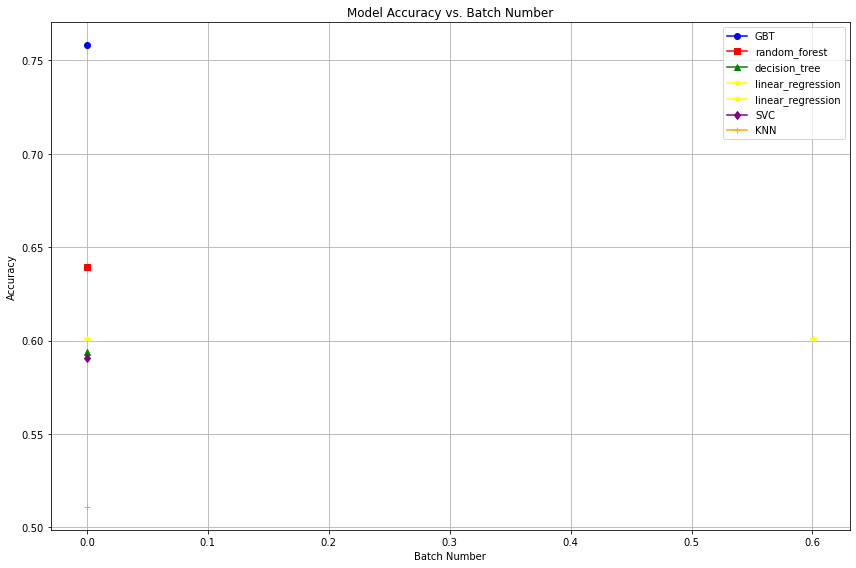

added features


fill NA in cols


convert string cols
sumerize features


remove redundant features


24/08/21 20:48:53 WARN DAGScheduler: Broadcasting large task binary with size 1117.4 KiB
24/08/21 20:50:04 WARN DAGScheduler: Broadcasting large task binary with size 1130.2 KiB
24/08/21 20:50:06 WARN DAGScheduler: Broadcasting large task binary with size 1136.6 KiB


Accuracy: 51.29%


24/08/21 20:51:17 WARN DAGScheduler: Broadcasting large task binary with size 1001.8 KiB
24/08/21 20:51:18 WARN DAGScheduler: Broadcasting large task binary with size 1004.2 KiB
24/08/21 20:51:19 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
24/08/21 20:51:20 WARN DAGScheduler: Broadcasting large task binary with size 1005.3 KiB
24/08/21 20:51:21 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
24/08/21 20:51:22 WARN DAGScheduler: Broadcasting large task binary with size 1008.6 KiB
24/08/21 20:51:23 WARN DAGScheduler: Broadcasting large task binary with size 1011.3 KiB
24/08/21 20:51:23 WARN DAGScheduler: Broadcasting large task binary with size 1011.8 KiB
24/08/21 20:51:24 WARN DAGScheduler: Broadcasting large task binary with size 1012.5 KiB
24/08/21 20:51:25 WARN DAGScheduler: Broadcasting large task binary with size 1013.5 KiB
24/08/21 20:51:26 WARN DAGScheduler: Broadcasting large task binary with size 1015.7 KiB
24/08/21 20:51:27 WAR

Accuracy on test data: 0.7021276595744681


Accuracy on test data: 0.6150740242261103


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1879846E7,1.57...|     1|       1.0|
|[1.1911051E7,1.57...|     1|       1.0|
|[1.1937581E7,1.57...|     1|       1.0|
|[1.1950869E7,1.57...|     0|       1.0|
|[1.1919491E7,1.57...|     1|       0.0|
+--------------------+------+----------+
only showing top 5 rows



24/08/21 20:56:06 WARN DAGScheduler: Broadcasting large task binary with size 1015.9 KiB


Accuracy on test data: 0.6352624495289367


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1879846E7,1.57...|     1|       1.0|
|[1.1911051E7,1.57...|     1|       1.0|
|[1.1937581E7,1.57...|     1|       1.0|
|[1.1950869E7,1.57...|     0|       1.0|
|[1.1919491E7,1.57...|     1|       1.0|
+--------------------+------+----------+
only showing top 5 rows



Accuracy on test data: 0.6036339165545087


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1879846E7,1.57...|     1|       1.0|
|[1.1911051E7,1.57...|     1|       1.0|
|[1.1937581E7,1.57...|     1|       0.0|
|[1.1950869E7,1.57...|     0|       1.0|
|[1.1919491E7,1.57...|     1|       1.0|
+--------------------+------+----------+
only showing top 5 rows



Accuracy on test data: 0.6117092866756393


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1879846E7,1.57...|     1|       1.0|
|[1.1911051E7,1.57...|     1|       1.0|
|[1.1937581E7,1.57...|     1|       0.0|
|[1.1950869E7,1.57...|     0|       1.0|
|[1.1919491E7,1.57...|     1|       0.0|
+--------------------+------+----------+
only showing top 5 rows



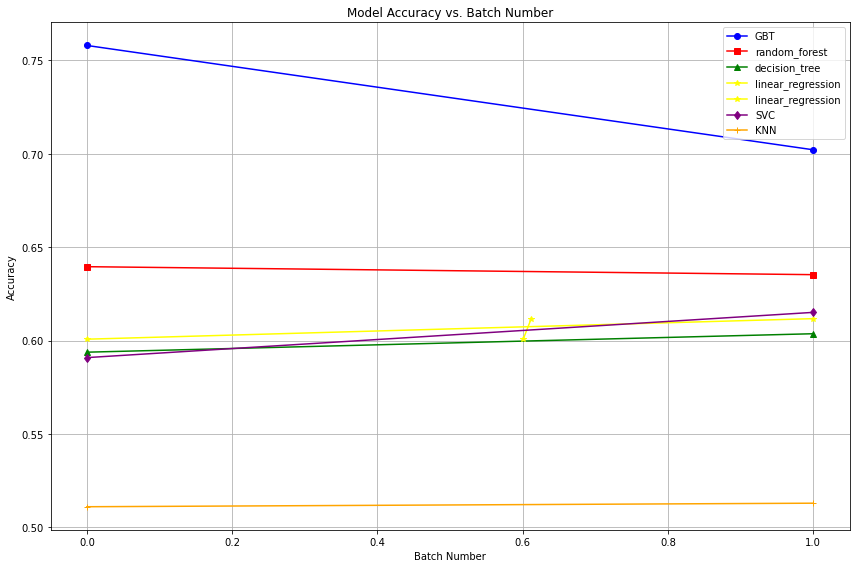

added features


fill NA in cols


convert string cols
sumerize features


remove redundant features


24/08/21 21:03:22 WARN DAGScheduler: Broadcasting large task binary with size 1117.4 KiB
24/08/21 21:04:39 WARN DAGScheduler: Broadcasting large task binary with size 1130.2 KiB
24/08/21 21:04:41 WARN TaskMemoryManager: Failed to allocate a page (67108864 bytes), try again.
24/08/21 21:04:43 WARN DAGScheduler: Broadcasting large task binary with size 1136.6 KiB


Accuracy: 49.92%


24/08/21 21:05:53 WARN DAGScheduler: Broadcasting large task binary with size 1000.2 KiB
24/08/21 21:05:54 WARN DAGScheduler: Broadcasting large task binary with size 1002.1 KiB
24/08/21 21:05:55 WARN DAGScheduler: Broadcasting large task binary with size 1004.0 KiB
24/08/21 21:05:55 WARN DAGScheduler: Broadcasting large task binary with size 1004.5 KiB
24/08/21 21:05:56 WARN DAGScheduler: Broadcasting large task binary with size 1005.2 KiB
24/08/21 21:05:57 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
24/08/21 21:05:58 WARN DAGScheduler: Broadcasting large task binary with size 1008.1 KiB
24/08/21 21:05:59 WARN DAGScheduler: Broadcasting large task binary with size 1009.8 KiB
24/08/21 21:06:00 WARN DAGScheduler: Broadcasting large task binary with size 1010.3 KiB
24/08/21 21:06:01 WARN DAGScheduler: Broadcasting large task binary with size 1011.0 KiB
24/08/21 21:06:02 WARN DAGScheduler: Broadcasting large task binary with size 1012.0 KiB
24/08/21 21:06:03 WAR

Accuracy on test data: 0.7034574468085106


Accuracy on test data: 0.6014397905759162


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1934235E7,1.57...|     1|       1.0|
|[1.1941411E7,1.57...|     1|       1.0|
|[1.1865473E7,1.57...|     0|       1.0|
|(35,[0,1,2,3,4,5,...|     1|       0.0|
|[1.1960516E7,1.57...|     0|       1.0|
+--------------------+------+----------+
only showing top 5 rows



24/08/21 21:11:04 WARN DAGScheduler: Broadcasting large task binary with size 1017.8 KiB


Accuracy on test data: 0.6420157068062827


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1934235E7,1.57...|     1|       1.0|
|[1.1941411E7,1.57...|     1|       1.0|
|[1.1865473E7,1.57...|     0|       1.0|
|(35,[0,1,2,3,4,5,...|     1|       1.0|
|[1.1960516E7,1.57...|     0|       1.0|
+--------------------+------+----------+
only showing top 5 rows



Accuracy on test data: 0.6073298429319371


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1934235E7,1.57...|     1|       1.0|
|[1.1941411E7,1.57...|     1|       1.0|
|[1.1865473E7,1.57...|     0|       1.0|
|(35,[0,1,2,3,4,5,...|     1|       1.0|
|[1.1960516E7,1.57...|     0|       0.0|
+--------------------+------+----------+
only showing top 5 rows



Accuracy on test data: 0.6


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1983503E7,1.57...|     1|       0.0|
|[1.1883002E7,1.57...|     0|       1.0|
|[1.1701176E7,1.57...|     1|       0.0|
|[1.198361E7,1.575...|     1|       1.0|
|[1.1906117E7,1.57...|     1|       1.0|
+--------------------+------+----------+
only showing top 5 rows



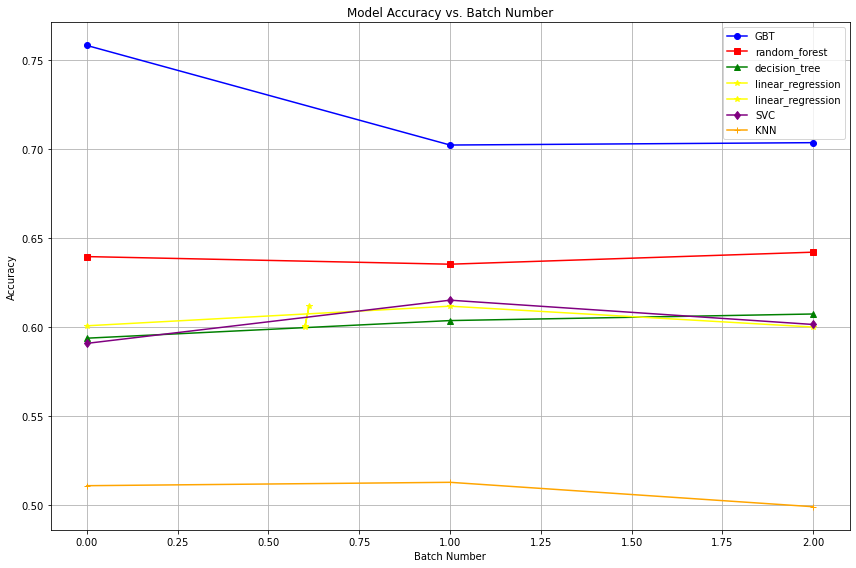

added features


fill NA in cols


convert string cols
sumerize features


remove redundant features


24/08/21 21:18:19 WARN DAGScheduler: Broadcasting large task binary with size 1117.4 KiB
24/08/21 21:19:42 WARN DAGScheduler: Broadcasting large task binary with size 1130.2 KiB
24/08/21 21:19:45 WARN DAGScheduler: Broadcasting large task binary with size 1136.6 KiB


Accuracy: 52.00%


24/08/21 21:20:58 WARN DAGScheduler: Broadcasting large task binary with size 1000.0 KiB
24/08/21 21:20:59 WARN DAGScheduler: Broadcasting large task binary with size 1002.3 KiB
24/08/21 21:21:00 WARN DAGScheduler: Broadcasting large task binary with size 1004.8 KiB
24/08/21 21:21:01 WARN DAGScheduler: Broadcasting large task binary with size 1005.3 KiB
24/08/21 21:21:02 WARN DAGScheduler: Broadcasting large task binary with size 1006.0 KiB
24/08/21 21:21:03 WARN DAGScheduler: Broadcasting large task binary with size 1007.0 KiB
24/08/21 21:21:04 WARN DAGScheduler: Broadcasting large task binary with size 1009.3 KiB
24/08/21 21:21:05 WARN DAGScheduler: Broadcasting large task binary with size 1011.8 KiB
24/08/21 21:21:06 WARN DAGScheduler: Broadcasting large task binary with size 1012.3 KiB
24/08/21 21:21:07 WARN DAGScheduler: Broadcasting large task binary with size 1013.0 KiB
24/08/21 21:21:08 WARN DAGScheduler: Broadcasting large task binary with size 1014.0 KiB
24/08/21 21:21:09 WAR

Accuracy on test data: 0.7271028037383177


Accuracy on test data: 0.5895249695493301


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1880155E7,1.57...|     1|       0.0|
|[1.1957392E7,1.57...|     1|       1.0|
|[1.1904493E7,1.57...|     1|       1.0|
|[1.1962419E7,1.57...|     0|       0.0|
|[1.1946521E7,1.57...|     1|       1.0|
+--------------------+------+----------+
only showing top 5 rows



24/08/21 21:26:11 WARN DAGScheduler: Broadcasting large task binary with size 1018.0 KiB


Accuracy on test data: 0.6303288672350792


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1880155E7,1.57...|     1|       0.0|
|[1.1957392E7,1.57...|     1|       1.0|
|[1.1904493E7,1.57...|     1|       1.0|
|[1.1962419E7,1.57...|     0|       0.0|
|[1.1946521E7,1.57...|     1|       1.0|
+--------------------+------+----------+
only showing top 5 rows



Accuracy on test data: 0.584652862362972


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1880155E7,1.57...|     1|       1.0|
|[1.1957392E7,1.57...|     1|       1.0|
|[1.1904493E7,1.57...|     1|       1.0|
|[1.1962419E7,1.57...|     0|       0.0|
|[1.1946521E7,1.57...|     1|       0.0|
+--------------------+------+----------+
only showing top 5 rows



Accuracy on test data: 0.5858708891595615


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1880155E7,1.57...|     1|       0.0|
|[1.1957392E7,1.57...|     1|       1.0|
|[1.1904493E7,1.57...|     1|       1.0|
|[1.1962419E7,1.57...|     0|       0.0|
|[1.1946521E7,1.57...|     1|       1.0|
+--------------------+------+----------+
only showing top 5 rows



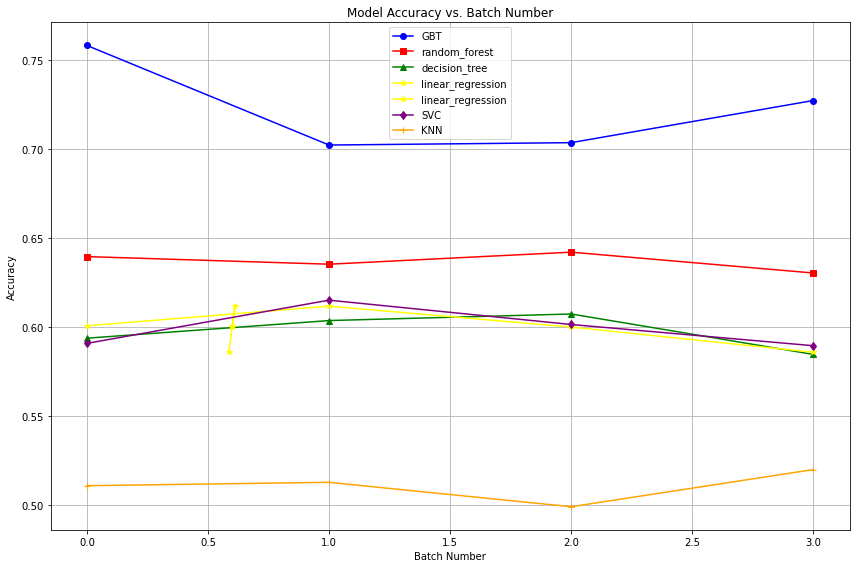

added features


fill NA in cols


convert string cols
sumerize features


remove redundant features


24/08/21 21:33:29 WARN DAGScheduler: Broadcasting large task binary with size 1117.4 KiB
24/08/21 21:35:02 WARN DAGScheduler: Broadcasting large task binary with size 1130.2 KiB
24/08/21 21:35:06 WARN DAGScheduler: Broadcasting large task binary with size 1136.6 KiB


Accuracy: 49.66%


24/08/21 21:36:16 WARN DAGScheduler: Broadcasting large task binary with size 1000.3 KiB
24/08/21 21:36:17 WARN DAGScheduler: Broadcasting large task binary with size 1001.0 KiB
24/08/21 21:36:18 WARN DAGScheduler: Broadcasting large task binary with size 1002.0 KiB
24/08/21 21:36:19 WARN DAGScheduler: Broadcasting large task binary with size 1003.7 KiB
24/08/21 21:36:20 WARN DAGScheduler: Broadcasting large task binary with size 1005.6 KiB
24/08/21 21:36:21 WARN DAGScheduler: Broadcasting large task binary with size 1006.1 KiB
24/08/21 21:36:22 WARN DAGScheduler: Broadcasting large task binary with size 1006.7 KiB
24/08/21 21:36:23 WARN DAGScheduler: Broadcasting large task binary with size 1007.5 KiB
24/08/21 21:36:24 WARN DAGScheduler: Broadcasting large task binary with size 1009.2 KiB
24/08/21 21:36:25 WARN DAGScheduler: Broadcasting large task binary with size 1011.5 KiB
24/08/21 21:36:26 WARN DAGScheduler: Broadcasting large task binary with size 1012.0 KiB
24/08/21 21:36:27 WAR

Accuracy on test data: 0.7573998839233894


Accuracy on test data: 0.596053395240859


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1936345E7,1.57...|     1|       1.0|
|[1.1983541E7,1.57...|     0|       0.0|
|[1.1930796E7,1.57...|     1|       1.0|
|[1.185853E7,1.575...|     1|       1.0|
|[1.1946954E7,1.57...|     0|       1.0|
+--------------------+------+----------+
only showing top 5 rows



24/08/21 21:41:27 WARN DAGScheduler: Broadcasting large task binary with size 1018.1 KiB


Accuracy on test data: 0.6343586767266396


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1936345E7,1.57...|     1|       1.0|
|[1.1983541E7,1.57...|     0|       0.0|
|[1.1930796E7,1.57...|     1|       1.0|
|[1.185853E7,1.575...|     1|       1.0|
|[1.1946954E7,1.57...|     0|       0.0|
+--------------------+------+----------+
only showing top 5 rows



Accuracy on test data: 0.6006964596633778


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1936345E7,1.57...|     1|       1.0|
|[1.1983541E7,1.57...|     0|       1.0|
|[1.1930796E7,1.57...|     1|       1.0|
|[1.185853E7,1.575...|     1|       1.0|
|[1.1946954E7,1.57...|     0|       1.0|
+--------------------+------+----------+
only showing top 5 rows



Accuracy on test data: 0.621867881548975


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1901023E7,1.57...|     0|       1.0|
|[1.1964385E7,1.57...|     1|       1.0|
|[1.1893448E7,1.57...|     0|       0.0|
|[1.189251E7,1.575...|     1|       1.0|
|[1.194652E7,1.575...|     1|       0.0|
+--------------------+------+----------+
only showing top 5 rows



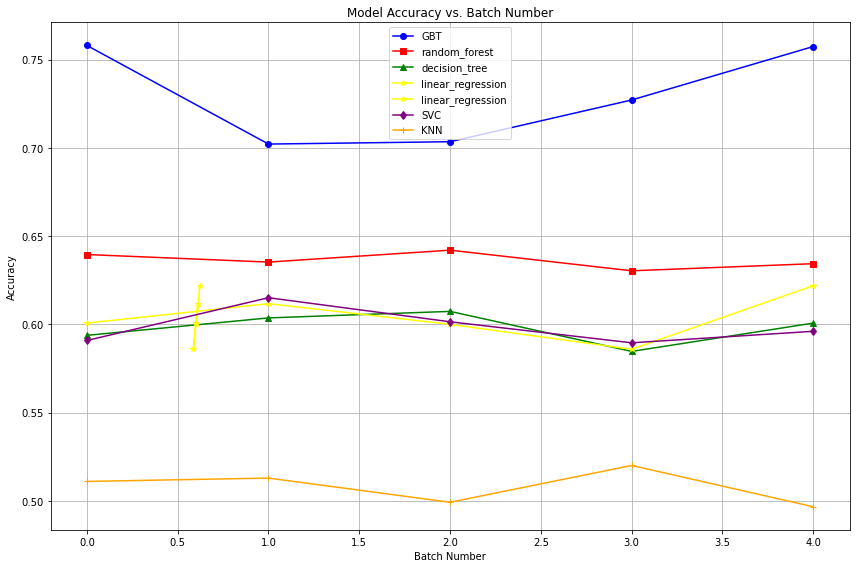

added features


fill NA in cols


convert string cols
sumerize features


remove redundant features


24/08/21 21:48:53 WARN DAGScheduler: Broadcasting large task binary with size 1138.7 KiB
24/08/21 21:51:01 WARN DAGScheduler: Broadcasting large task binary with size 1151.4 KiB
24/08/21 21:51:05 WARN DAGScheduler: Broadcasting large task binary with size 1157.8 KiB


Accuracy: 52.13%


24/08/21 21:52:00 WARN DAGScheduler: Broadcasting large task binary with size 1000.4 KiB
24/08/21 21:52:01 WARN DAGScheduler: Broadcasting large task binary with size 1001.4 KiB
24/08/21 21:52:02 WARN DAGScheduler: Broadcasting large task binary with size 1003.6 KiB
24/08/21 21:52:03 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
24/08/21 21:52:04 WARN DAGScheduler: Broadcasting large task binary with size 1006.8 KiB
24/08/21 21:52:05 WARN DAGScheduler: Broadcasting large task binary with size 1007.5 KiB
24/08/21 21:52:06 WARN DAGScheduler: Broadcasting large task binary with size 1008.5 KiB
24/08/21 21:52:07 WARN DAGScheduler: Broadcasting large task binary with size 1010.8 KiB
24/08/21 21:52:08 WARN DAGScheduler: Broadcasting large task binary with size 1013.3 KiB
24/08/21 21:52:09 WARN DAGScheduler: Broadcasting large task binary with size 1013.8 KiB
24/08/21 21:52:10 WARN DAGScheduler: Broadcasting large task binary with size 1014.5 KiB
24/08/21 21:52:11 WAR

Accuracy on test data: 0.6933187294633077


Accuracy on test data: 0.6166666666666667


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.193454E7,1.575...|     0|       0.0|
|[1.1956958E7,1.57...|     0|       1.0|
|[1.1957405E7,1.57...|     1|       1.0|
|[1.1943479E7,1.57...|     0|       0.0|
|[1.1969957E7,1.57...|     0|       0.0|
+--------------------+------+----------+
only showing top 5 rows



24/08/21 21:56:59 WARN DAGScheduler: Broadcasting large task binary with size 1017.2 KiB
24/08/21 21:57:17 WARN DAGScheduler: Broadcasting large task binary with size 1037.9 KiB


Accuracy on test data: 0.6591397849462366


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.193454E7,1.575...|     0|       0.0|
|[1.1956958E7,1.57...|     0|       1.0|
|[1.1957405E7,1.57...|     1|       1.0|
|[1.1943479E7,1.57...|     0|       0.0|
|[1.1969957E7,1.57...|     0|       0.0|
+--------------------+------+----------+
only showing top 5 rows



Accuracy on test data: 0.621505376344086


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.193454E7,1.575...|     0|       0.0|
|[1.1956958E7,1.57...|     0|       1.0|
|[1.1957405E7,1.57...|     1|       1.0|
|[1.1943479E7,1.57...|     0|       0.0|
|[1.1969957E7,1.57...|     0|       0.0|
+--------------------+------+----------+
only showing top 5 rows



Accuracy on test data: 0.617741935483871


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.193454E7,1.575...|     0|       0.0|
|[1.1956958E7,1.57...|     0|       1.0|
|[1.1957405E7,1.57...|     1|       1.0|
|[1.1943479E7,1.57...|     0|       0.0|
|[1.1969957E7,1.57...|     0|       0.0|
+--------------------+------+----------+
only showing top 5 rows



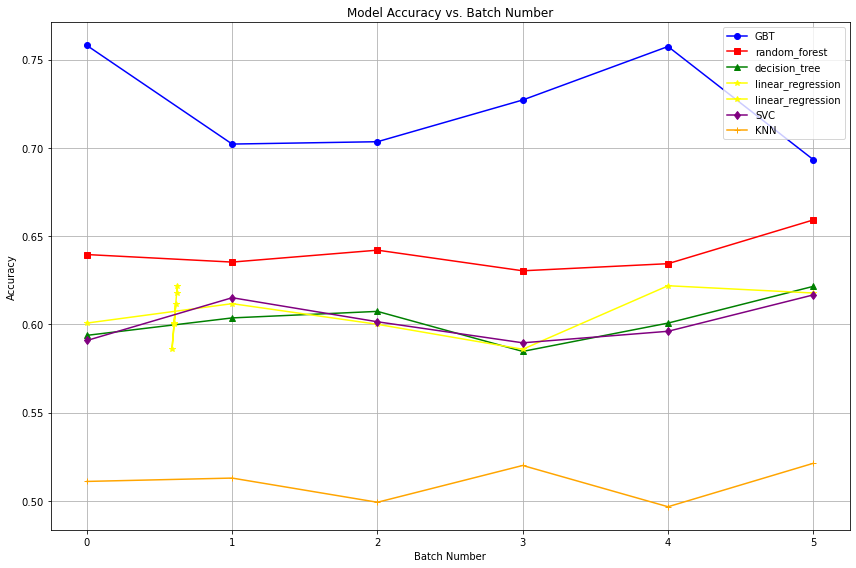

added features


fill NA in cols


convert string cols
sumerize features


24/08/21 22:03:20 WARN InternalKafkaConsumerPool: Pool exceeds its soft max size, cleaning up idle objects...


remove redundant features


24/08/21 22:04:34 WARN DAGScheduler: Broadcasting large task binary with size 1162.4 KiB
24/08/21 22:06:23 WARN DAGScheduler: Broadcasting large task binary with size 1175.2 KiB
24/08/21 22:06:27 WARN DAGScheduler: Broadcasting large task binary with size 1181.6 KiB


Accuracy: 51.52%


24/08/21 22:07:08 WARN DAGScheduler: Broadcasting large task binary with size 1001.3 KiB
24/08/21 22:07:09 WARN DAGScheduler: Broadcasting large task binary with size 1003.2 KiB
24/08/21 22:07:10 WARN DAGScheduler: Broadcasting large task binary with size 1003.7 KiB
24/08/21 22:07:11 WARN DAGScheduler: Broadcasting large task binary with size 1004.4 KiB
24/08/21 22:07:12 WARN DAGScheduler: Broadcasting large task binary with size 1005.1 KiB
24/08/21 22:07:12 WARN DAGScheduler: Broadcasting large task binary with size 1006.5 KiB
24/08/21 22:07:13 WARN DAGScheduler: Broadcasting large task binary with size 1008.7 KiB
24/08/21 22:07:14 WARN DAGScheduler: Broadcasting large task binary with size 1009.2 KiB
24/08/21 22:07:15 WARN DAGScheduler: Broadcasting large task binary with size 1009.9 KiB
24/08/21 22:07:16 WARN DAGScheduler: Broadcasting large task binary with size 1010.9 KiB
24/08/21 22:07:17 WARN DAGScheduler: Broadcasting large task binary with size 1013.1 KiB
24/08/21 22:07:18 WAR

Accuracy on test data: 0.7489361702127659


Accuracy on test data: 0.5925531914893617


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1946955E7,1.57...|     0|       1.0|
|[1.1880156E7,1.57...|     1|       1.0|
|[1.1983591E7,1.57...|     0|       1.0|
|[1.1948791E7,1.57...|     1|       0.0|
|[1.1977431E7,1.57...|     1|       1.0|
+--------------------+------+----------+
only showing top 5 rows



24/08/21 22:12:36 WARN DAGScheduler: Broadcasting large task binary with size 1001.8 KiB
24/08/21 22:12:37 WARN DAGScheduler: Broadcasting large task binary with size 1044.0 KiB
24/08/21 22:12:55 WARN DAGScheduler: Broadcasting large task binary with size 1062.1 KiB


Accuracy on test data: 0.6196808510638298


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1946955E7,1.57...|     0|       1.0|
|[1.1880156E7,1.57...|     1|       1.0|
|[1.1983591E7,1.57...|     0|       1.0|
|[1.1948791E7,1.57...|     1|       1.0|
|[1.1977431E7,1.57...|     1|       1.0|
+--------------------+------+----------+
only showing top 5 rows



Accuracy on test data: 0.592901878914405


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1891437E7,1.57...|     1|       1.0|
|[1.1972148E7,1.57...|     1|       0.0|
|[1.1979247E7,1.57...|     1|       1.0|
|[1.1909911E7,1.57...|     0|       1.0|
|[1.1887942E7,1.57...|     1|       1.0|
+--------------------+------+----------+
only showing top 5 rows



Accuracy on test data: 0.5944676409185804


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1891437E7,1.57...|     1|       1.0|
|[1.1972148E7,1.57...|     1|       1.0|
|[1.1979247E7,1.57...|     1|       1.0|
|[1.1909911E7,1.57...|     0|       1.0|
|[1.1887942E7,1.57...|     1|       1.0|
+--------------------+------+----------+
only showing top 5 rows



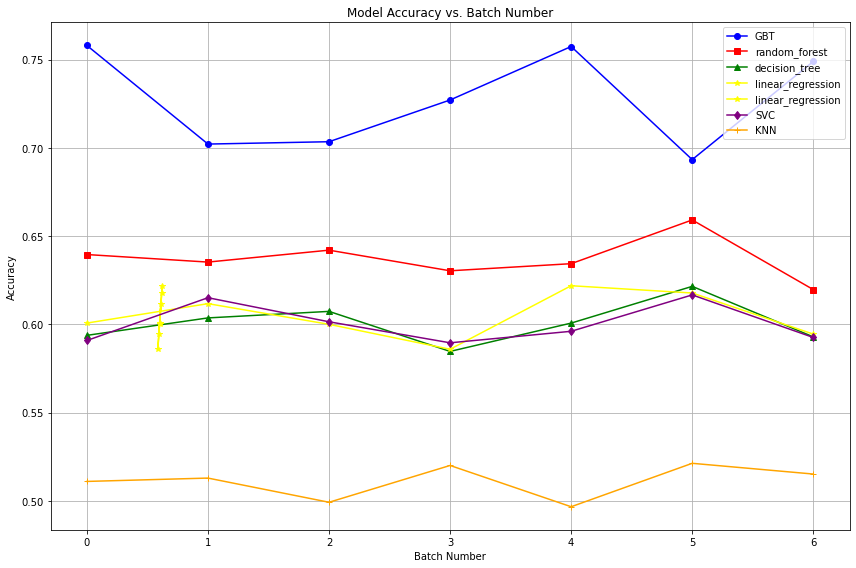

added features


fill NA in cols


convert string cols
sumerize features


remove redundant features


24/08/21 22:20:27 WARN DAGScheduler: Broadcasting large task binary with size 1178.1 KiB
24/08/21 22:22:27 WARN DAGScheduler: Broadcasting large task binary with size 1190.9 KiB
24/08/21 22:22:32 WARN DAGScheduler: Broadcasting large task binary with size 1197.3 KiB


Accuracy: 49.74%


24/08/21 22:23:00 WARN DAGScheduler: Broadcasting large task binary with size 1000.1 KiB
24/08/21 22:23:01 WARN DAGScheduler: Broadcasting large task binary with size 1000.6 KiB
24/08/21 22:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1001.3 KiB
24/08/21 22:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1002.3 KiB
24/08/21 22:23:04 WARN DAGScheduler: Broadcasting large task binary with size 1004.2 KiB
24/08/21 22:23:05 WARN DAGScheduler: Broadcasting large task binary with size 1006.4 KiB
24/08/21 22:23:07 WARN DAGScheduler: Broadcasting large task binary with size 1006.9 KiB
24/08/21 22:23:08 WARN DAGScheduler: Broadcasting large task binary with size 1007.6 KiB
24/08/21 22:23:09 WARN DAGScheduler: Broadcasting large task binary with size 1008.6 KiB
24/08/21 22:23:10 WARN DAGScheduler: Broadcasting large task binary with size 1010.9 KiB
24/08/21 22:23:11 WARN DAGScheduler: Broadcasting large task binary with size 1013.4 KiB
24/08/21 22:23:12 WAR

Accuracy on test data: 0.6770996348461137


Accuracy on test data: 0.5849153412006157


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1905314E7,1.57...|     0|       0.0|
|[1.193362E7,1.575...|     1|       1.0|
|[1.1878683E7,1.57...|     0|       1.0|
|[1.1946269E7,1.57...|     0|       1.0|
|[1.1877001E7,1.57...|     1|       1.0|
+--------------------+------+----------+
only showing top 5 rows



24/08/21 22:29:05 WARN DAGScheduler: Broadcasting large task binary with size 1017.5 KiB
24/08/21 22:29:07 WARN DAGScheduler: Broadcasting large task binary with size 1059.4 KiB
24/08/21 22:29:25 WARN DAGScheduler: Broadcasting large task binary with size 1075.3 KiB


Accuracy on test data: 0.6187788609543355


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1905314E7,1.57...|     0|       0.0|
|[1.193362E7,1.575...|     1|       1.0|
|[1.1878683E7,1.57...|     0|       1.0|
|[1.1946269E7,1.57...|     0|       1.0|
|[1.1877001E7,1.57...|     1|       1.0|
+--------------------+------+----------+
only showing top 5 rows



Accuracy on test data: 0.5895330938943047


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1905314E7,1.57...|     0|       1.0|
|[1.193362E7,1.575...|     1|       1.0|
|[1.1878683E7,1.57...|     0|       1.0|
|[1.1946269E7,1.57...|     0|       1.0|
|[1.1877001E7,1.57...|     1|       1.0|
+--------------------+------+----------+
only showing top 5 rows



Accuracy on test data: 0.5961538461538461


+--------------------+------+----------+
|            features|target|prediction|
+--------------------+------+----------+
|[1.1891437E7,1.57...|     1|       1.0|
|[1.1962809E7,1.57...|     1|       1.0|
|[1.1874879E7,1.57...|     0|       1.0|
|[1.1985556E7,1.57...|     0|       0.0|
|[1.1935277E7,1.57...|     1|       1.0|
+--------------------+------+----------+
only showing top 5 rows



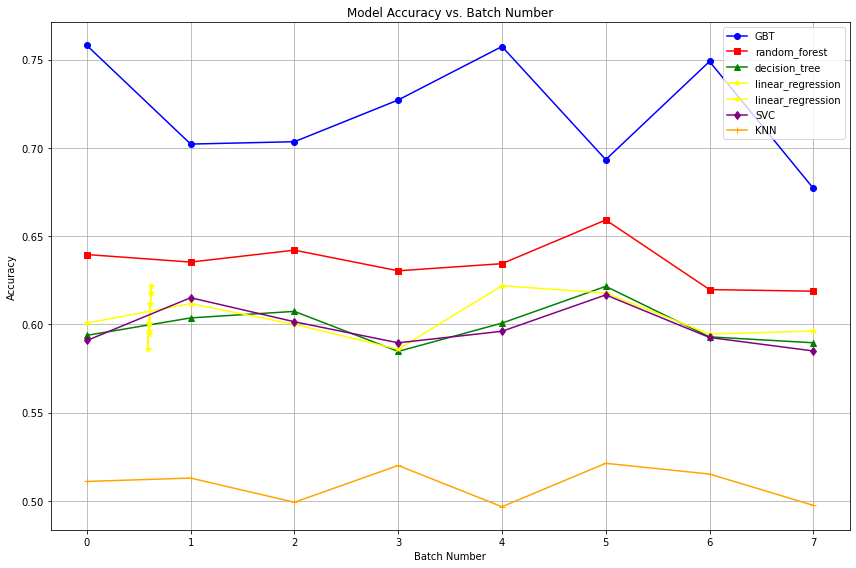

added features


fill NA in cols


convert string cols
sumerize features


remove redundant features


24/08/21 22:37:08 WARN DAGScheduler: Broadcasting large task binary with size 1202.6 KiB
24/08/21 22:39:18 WARN DAGScheduler: Broadcasting large task binary with size 1215.4 KiB


[7811.874s][warning][gc,alloc] Executor task launch worker for task 2.0 in stage 20064.0 (TID 456547): Retried waiting for GCLocker too often allocating 8388610 words


24/08/21 22:39:20 WARN TaskMemoryManager: Failed to allocate a page (67108864 bytes), try again.
24/08/21 22:39:21 WARN TaskMemoryManager: Failed to allocate a page (46110299 bytes), try again.
24/08/21 22:39:21 ERROR Executor: Exception in task 2.0 in stage 20064.0 (TID 456547)
org.apache.spark.memory.SparkOutOfMemoryError: [UNABLE_TO_ACQUIRE_MEMORY] Unable to acquire 65536 bytes of memory, got 0.
	at org.apache.spark.errors.SparkCoreErrors$.outOfMemoryError(SparkCoreErrors.scala:467)
	at org.apache.spark.errors.SparkCoreErrors.outOfMemoryError(SparkCoreErrors.scala)
	at org.apache.spark.memory.MemoryConsumer.throwOom(MemoryConsumer.java:157)
	at org.apache.spark.memory.MemoryConsumer.allocateArray(MemoryConsumer.java:98)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.growPointerArrayIfNecessary(UnsafeExternalSorter.java:415)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.allocateMemoryForRecordIfNecessary(UnsafeExternalSorter.java:449)
	a

24/08/21 22:39:23 WARN TaskSetManager: Lost task 4.0 in stage 20064.0 (TID 456549) (192.168.90.19 executor driver): TaskKilled (Stage cancelled: Job aborted due to stage failure: Task 2 in stage 20064.0 failed 1 times, most recent failure: Lost task 2.0 in stage 20064.0 (TID 456547) (192.168.90.19 executor driver): org.apache.spark.memory.SparkOutOfMemoryError: [UNABLE_TO_ACQUIRE_MEMORY] Unable to acquire 65536 bytes of memory, got 0.
	at org.apache.spark.errors.SparkCoreErrors$.outOfMemoryError(SparkCoreErrors.scala:467)
	at org.apache.spark.errors.SparkCoreErrors.outOfMemoryError(SparkCoreErrors.scala)
	at org.apache.spark.memory.MemoryConsumer.throwOom(MemoryConsumer.java:157)
	at org.apache.spark.memory.MemoryConsumer.allocateArray(MemoryConsumer.java:98)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.growPointerArrayIfNecessary(UnsafeExternalSorter.java:415)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.allocateMemoryForRecordIfNecess

Py4JJavaError: An error occurred while calling o40782.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 20064.0 failed 1 times, most recent failure: Lost task 2.0 in stage 20064.0 (TID 456547) (192.168.90.19 executor driver): org.apache.spark.memory.SparkOutOfMemoryError: [UNABLE_TO_ACQUIRE_MEMORY] Unable to acquire 65536 bytes of memory, got 0.
	at org.apache.spark.errors.SparkCoreErrors$.outOfMemoryError(SparkCoreErrors.scala:467)
	at org.apache.spark.errors.SparkCoreErrors.outOfMemoryError(SparkCoreErrors.scala)
	at org.apache.spark.memory.MemoryConsumer.throwOom(MemoryConsumer.java:157)
	at org.apache.spark.memory.MemoryConsumer.allocateArray(MemoryConsumer.java:98)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.growPointerArrayIfNecessary(UnsafeExternalSorter.java:415)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.allocateMemoryForRecordIfNecessary(UnsafeExternalSorter.java:449)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:487)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage7.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage7.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.window.GroupedLimitIterator.fetchNextRow(WindowGroupLimitExec.scala:213)
	at org.apache.spark.sql.execution.window.GroupedLimitIterator.<init>(WindowGroupLimitExec.scala:219)
	at org.apache.spark.sql.execution.window.WindowGroupLimitEvaluatorFactory.$anonfun$createEvaluator$4(WindowGroupLimitEvaluatorFactory.scala:50)
	at org.apache.spark.sql.execution.window.WindowGroupLimitEvaluatorFactory$WindowGroupLimitPartitionEvaluator.eval(WindowGroupLimitEvaluatorFactory.scala:60)
	at org.apache.spark.sql.execution.window.WindowGroupLimitExec.$anonfun$doExecute$1(WindowGroupLimitExec.scala:89)
	at org.apache.spark.sql.execution.window.WindowGroupLimitExec.$anonfun$doExecute$1$adapted(WindowGroupLimitExec.scala:87)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:877)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:877)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.memory.SparkOutOfMemoryError: [UNABLE_TO_ACQUIRE_MEMORY] Unable to acquire 65536 bytes of memory, got 0.
	at org.apache.spark.errors.SparkCoreErrors$.outOfMemoryError(SparkCoreErrors.scala:467)
	at org.apache.spark.errors.SparkCoreErrors.outOfMemoryError(SparkCoreErrors.scala)
	at org.apache.spark.memory.MemoryConsumer.throwOom(MemoryConsumer.java:157)
	at org.apache.spark.memory.MemoryConsumer.allocateArray(MemoryConsumer.java:98)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.growPointerArrayIfNecessary(UnsafeExternalSorter.java:415)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.allocateMemoryForRecordIfNecessary(UnsafeExternalSorter.java:449)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.insertRecord(UnsafeExternalSorter.java:487)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.insertRow(UnsafeExternalRowSorter.java:138)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage7.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage7.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.window.GroupedLimitIterator.fetchNextRow(WindowGroupLimitExec.scala:213)
	at org.apache.spark.sql.execution.window.GroupedLimitIterator.<init>(WindowGroupLimitExec.scala:219)
	at org.apache.spark.sql.execution.window.WindowGroupLimitEvaluatorFactory.$anonfun$createEvaluator$4(WindowGroupLimitEvaluatorFactory.scala:50)
	at org.apache.spark.sql.execution.window.WindowGroupLimitEvaluatorFactory$WindowGroupLimitPartitionEvaluator.eval(WindowGroupLimitEvaluatorFactory.scala:60)
	at org.apache.spark.sql.execution.window.WindowGroupLimitExec.$anonfun$doExecute$1(WindowGroupLimitExec.scala:89)
	at org.apache.spark.sql.execution.window.WindowGroupLimitExec.$anonfun$doExecute$1$adapted(WindowGroupLimitExec.scala:87)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:877)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:877)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [34]:
while True:
    # Read data from Kafka
    kafka_batch_df = spark \
        .read \
        .format("kafka") \
        .option("kafka.bootstrap.servers", kafka_bootstrap_servers) \
        .option("subscribe", kafka_topic) \
        .load()

    # Kafka messages are in a binary format, so decode and cast to String
    messages_df = kafka_batch_df.selectExpr("CAST(value AS STRING)")

    # Apply schema to the message values
    messages_df = messages_df.selectExpr("value as json").select(from_json(col("json"), schema).alias("data")).select("data.*")

    # Apply preprocessing function
    processed_df = preprocession(messages_df)

    models_preds(processed_df, GBT_List,
                random_forest_List, decision_tree_List,
                Linear_regression_List, SVC_List, KNN_List, count)

    plot_model_acc(GBT_List, random_forest_List, decision_tree_List,
                   Linear_regression_List, SVC_List)

    
    count += 1
    # Check for new data (Optional: Add sleep or delay to avoid excessive polling)
    if kafka_batch_df.count() == 0:
        print("No more data available. Exiting.")
        break
